In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [3]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

In [4]:
data_dir = 'extracted_images'
batch_size = 32
img_height = 45
img_width = 45

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=binarize)

In [6]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode="categorical",
        seed=123)

Found 375974 images belonging to 82 classes.


In [7]:
# Class names
class_names = [k for k,v in train_generator.class_indices.items()]
print(class_names)

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']


In [8]:
print(len(class_names))

82


In [9]:
num_classes = 82

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 45, 45, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 43, 43, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.fit(
  train_generator,
  epochs=3
)

Epoch 1/3
11750/11750 [==============================] - 8652s 736ms/step - loss: 0.4952 - accuracy: 0.8593
Epoch 2/3
11750/11750 [==============================] - 6819s 580ms/step - loss: 0.2526 - accuracy: 0.9212
Epoch 3/3
11750/11750 [==============================] - 5867s 499ms/step - loss: 0.1921 - accuracy: 0.9383


In [13]:
model.save('math_model')

INFO:tensorflow:Assets written to: math_model\assets


INFO:tensorflow:Assets written to: math_model\assets


In [15]:
image_dir = "image/"


In [24]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    inverted_binary_img = ~binarized

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 30: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

In [72]:
flag = 1#flag =1 for handwritten images,0 for drawn images
IMAGE = "image1.jpg"
img_path = "image/"+IMAGE
#plt.imshow(img_path)
#plt.show()

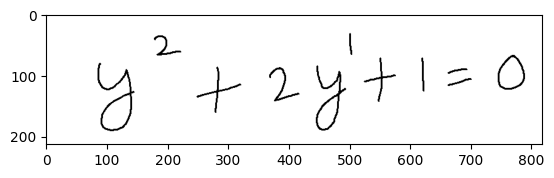

True

In [74]:
img_path = "D:\OCR_MATH\image\image1.jpg"  # Add your image path
input_image = cv2.imread(img_path, 0)  # Read as grayscale
ret, bw_img = cv2.threshold(input_image, 127, 255, cv2.THRESH_BINARY)
plt.imshow(bw_img, cmap='gray')  # Add cmap='gray' for grayscale
plt.show()

cv2.imwrite('image/image1.jpg', bw_img)


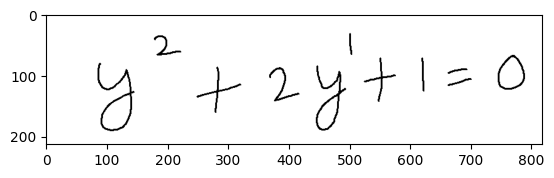

10


In [75]:
if flag == 1:
    input_image = cv2.imread(img_path) 
    ret, bw_img = cv2.threshold(input_image,127,255,cv2.THRESH_BINARY)
    plt.imshow(bw_img)
    plt.show()
    
    cv2.imwrite('image/image1.jpg', bw_img)

    input_image_cpy = bw_img.copy()
    keep = detect_contours(image_dir+'image1.jpg')
    print(len(keep))
    img_path = image_dir+'image1.jpg'
else:
    input_image = cv2.imread(img_path, 0) 
    input_image_cpy = input_image.copy()
    keep = detect_contours(image_dir+IMAGE)
    print(len(keep))

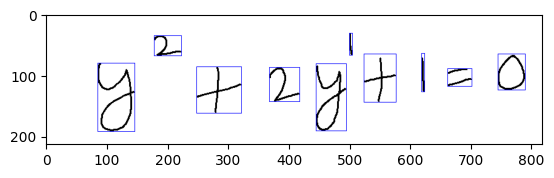

In [76]:
#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()

In [77]:
def resize_pad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [78]:
new_model = tf.keras.models.load_model('math_model')


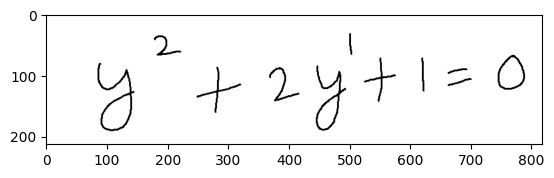

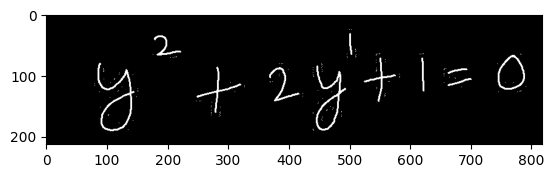

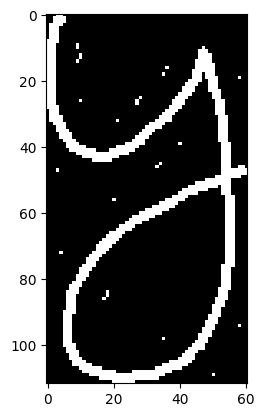

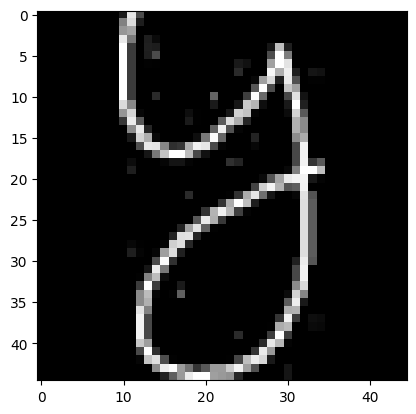

1/1 [==============================] - 0s 73ms/step
y


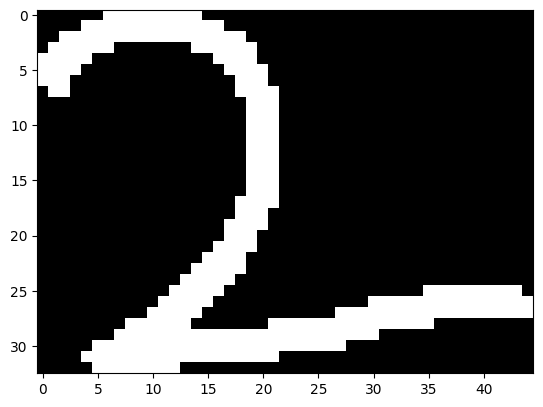

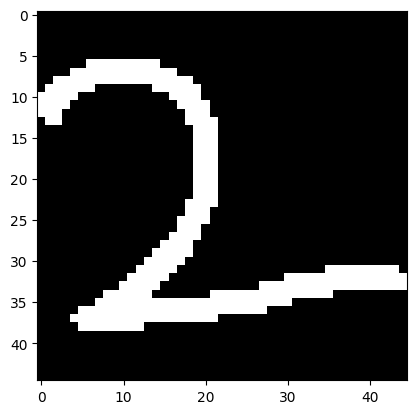

1/1 [==============================] - 0s 28ms/step
2


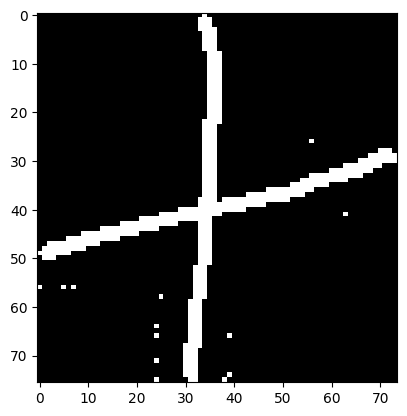

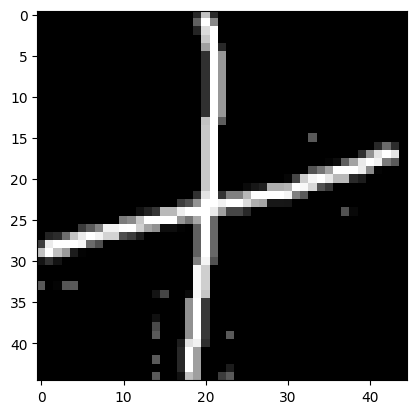

1/1 [==============================] - 0s 35ms/step
+


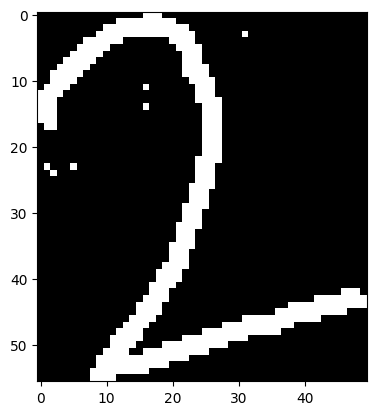

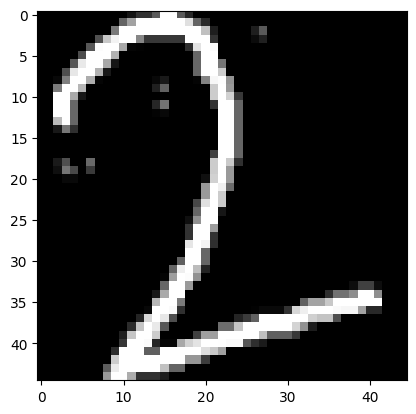

1/1 [==============================] - 0s 20ms/step
N


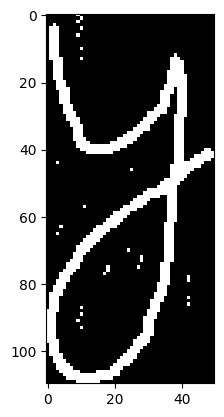

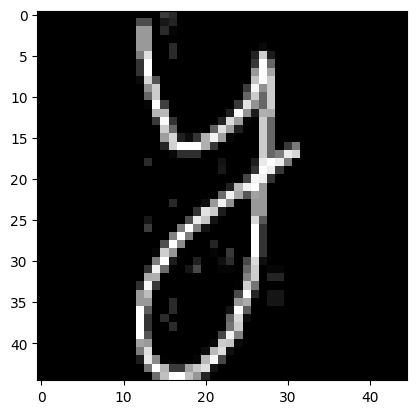

1/1 [==============================] - 0s 32ms/step
y


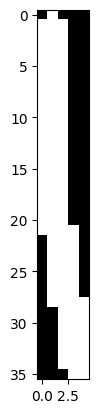

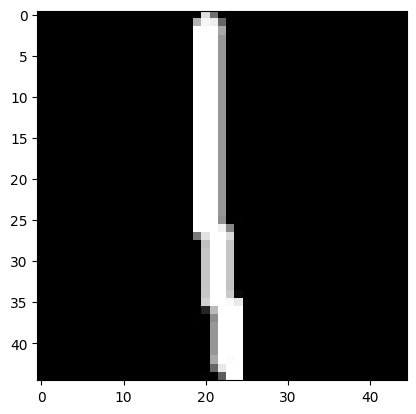

1/1 [==============================] - 0s 23ms/step
1


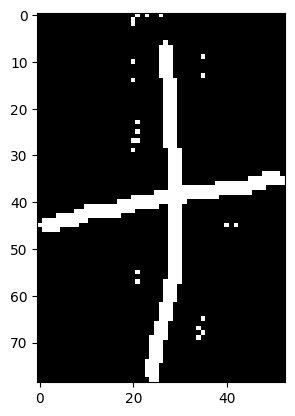

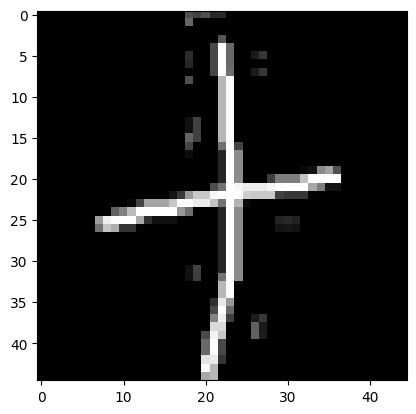

1/1 [==============================] - 0s 27ms/step
+


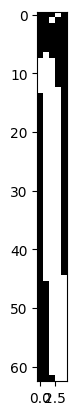

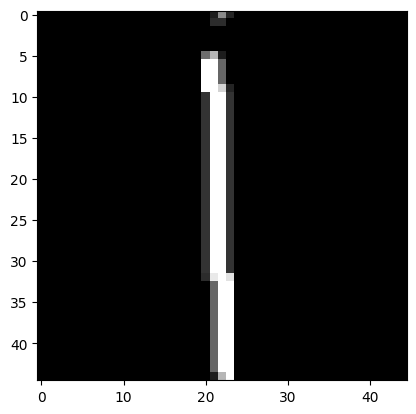

1/1 [==============================] - 0s 34ms/step
1


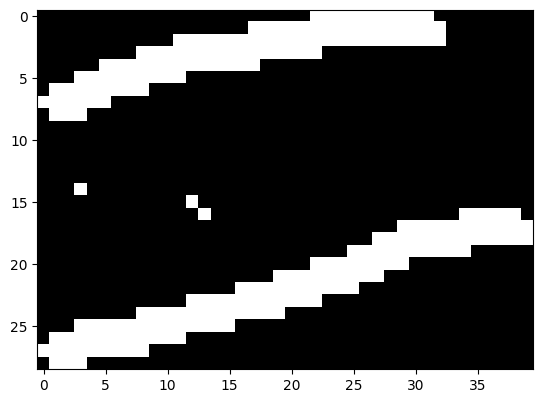

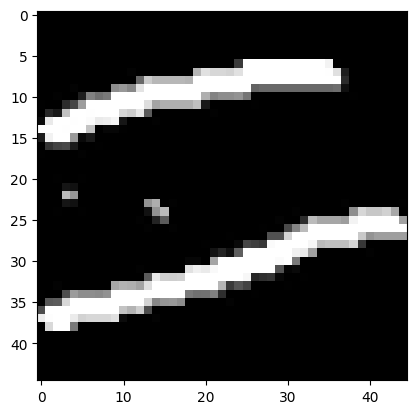

1/1 [==============================] - 0s 30ms/step
=


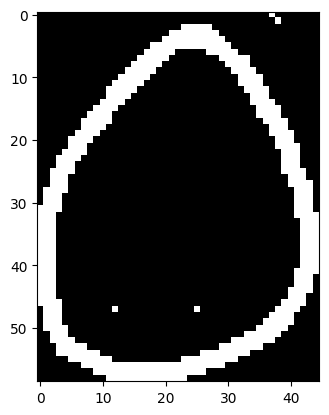

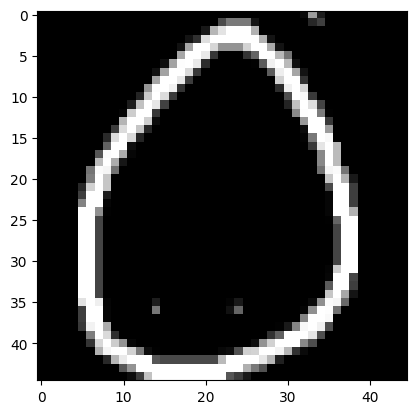

1/1 [==============================] - 0s 32ms/step
N
y2+Ny1+1=N


In [79]:
eqn_list = []

# binarize the input image
#IMAGE = "testing.png"
#img_path = "equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
inverted_binary_img = binarize(input_image)
plt.imshow(input_image,cmap = 'gray')
#cv2.waitKey(0)
plt.show()
plt.imshow(inverted_binary_img,cmap = 'gray')
plt.show()
#cv2.imshow('res1',inverted_binary_img)
#cv2.waitKey(0)

for (x, y, w, h) in sorted(keep, key = lambda x: x[0]):
    #cv2.imshow('res',inverted_binary_img[y:y+h, x:x+w])
    #cv2.waitKey(0)
    plt.imshow(inverted_binary_img[y:y+h, x:x+w],cmap = 'gray')
    plt.show()
    

    img = resize_pad(inverted_binary_img[y:y+h, x:x+w], (45, 45), 0) # We must use the binarized image to predict
    plt.imshow(img,cmap = 'gray')
    plt.show()
    pred_class = class_names[np.argmax(new_model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1)))]
    if pred_class == "times":
        pred_class = "*"
    eqn_list.append(pred_class)
    print(pred_class)
    #plt.imshow(img)
    #plt.show()
eqn = "".join(eqn_list)
print(eqn)

In [80]:
eval(eqn[0:])


SyntaxError: invalid syntax (<string>, line 1)

In [81]:


# Parse the equation properly
if "=" in eqn:
    left, right = eqn.split("=")
    left = left.strip()
    right = right.strip()
    
    # Handle the + at the beginning
    if left.startswith("+"):
        left = left[1:]  # Remove the +
    
    print(f"Left side: {left}")
    print(f"Right side: {right}")
    print(f"Is equation valid? {left == right}")


Left side: y2+Ny1+1
Right side: N
Is equation valid? False


In [82]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# 1. DATA LOADING AND PREPARATION
# -------------------------------

def parse_inkml(file_path):
    """Parses an InkML file to extract stroke coordinates."""
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        traces = []
        for trace in root.findall('{http://www.w3.org/2003/InkML}trace'):
            points = []
            for point in trace.text.strip().split(','):
                coords = point.strip().split()
                if len(coords) >= 2:
                    points.append([float(coords[0]), float(coords[1])])
            if points:
                traces.append(np.array(points, dtype=np.float32))
        return traces
    except ET.ParseError:
        return []

def normalize_traces(traces):
    """Normalizes all stroke points in a sample to a [0, 1] scale."""
    if not traces:
        return []
    all_points = np.vstack(traces)
    scaler = MinMaxScaler()
    all_points_scaled = scaler.fit_transform(all_points)
    
    normalized_traces = []
    idx = 0
    for trace in traces:
        n_points = len(trace)
        normalized_traces.append(all_points_scaled[idx:idx + n_points])
        idx += n_points
    return normalized_traces

def prepare_stroke_sequences(traces, max_len=500):
    """Converts normalized traces into a sequence of (dx, dy, pen_state)."""
    sequences = []
    for sample in traces:
        if not sample: continue
        seq = []
        for trace in sample:
            if len(trace) < 2: continue
            # Calculate dx, dy for the stroke
            deltas = trace[1:] - trace[:-1]
            
            # Create pen state: 0 for moving, 1 for pen-up at the end
            pen_states = np.zeros((len(deltas), 1))
            pen_states[-1, 0] = 1.0 
            
            # Combine deltas and pen state
            full_trace_seq = np.hstack([deltas, pen_states])
            seq.append(full_trace_seq)
        
        if not seq: continue
        full_sample_seq = np.vstack(seq)
        
        # Pad or truncate the sequence
        if len(full_sample_seq) > max_len:
            padded_seq = full_sample_seq[:max_len]
        else:
            pad_width = max_len - len(full_sample_seq)
            padded_seq = np.pad(full_sample_seq, ((0, pad_width), (0, 0)), 'constant')
            
        sequences.append(padded_seq)
    return np.array(sequences, dtype=np.float32)

def tokenize_labels(labels):
    """MODIFIED: Adds start/end tokens and tokenizes labels."""
    labels_with_tokens = [f"<start> {l} <end>" for l in labels]
    
    tokenizer = Tokenizer(char_level=False, filters='', lower=False, oov_token="<unk>")
    tokenizer.fit_on_texts(labels_with_tokens)
    
    sequences = tokenizer.texts_to_sequences(labels_with_tokens)
    sequences = pad_sequences(sequences, padding='post', truncating='post')
    return sequences, tokenizer

def load_dataset(folder_path):
    """Loads all data from a folder."""
    data = []
    labels = []
    for file_name in sorted(os.listdir(folder_path)): # sorted for consistency
        if file_name.endswith(".inkml"):
            file_path = os.path.join(folder_path, file_name)
            traces = parse_inkml(file_path)
            if not traces: continue
                
            traces = normalize_traces(traces)
            data.append(traces)
            
            tree = ET.parse(file_path)
            root = tree.getroot()
            normalized_label = root.find('{http://www.w3.org/2003/InkML}annotation[@type="normalizedLabel"]')
            labels.append(normalized_label.text if normalized_label is not None else "")
    return data, labels

# Load data (using smaller subsets for a quick example)
print("Loading data...")
train_data, train_labels = load_dataset("mathwriting-2024/train/")
valid_data, valid_labels = load_dataset("mathwriting-2024/valid/")

# For demonstration, use a small subset
train_data, train_labels = train_data[:1000], train_labels[:1000]
valid_data, valid_labels = valid_data[:200], valid_labels[:200]

# Tokenize labels
print("Tokenizing labels...")
all_labels = train_labels + valid_labels
sequences, tokenizer = tokenize_labels(all_labels)
train_sequences = sequences[:len(train_labels)]
valid_sequences = sequences[len(train_labels):]

# Prepare stroke data
print("Preparing stroke sequences...")
X_train = prepare_stroke_sequences(train_data, max_len=500)
X_valid = prepare_stroke_sequences(valid_data, max_len=500)

# Prepare data for teacher forcing in the decoder
decoder_input_train = train_sequences[:, :-1]
decoder_target_train = train_sequences[:, 1:]

decoder_input_valid = valid_sequences[:, :-1]
decoder_target_valid = valid_sequences[:, 1:]

print(f"X_train shape: {X_train.shape}")
print(f"Decoder input train shape: {decoder_input_train.shape}")
print(f"Decoder target train shape: {decoder_target_train.shape}")

Loading data...
Tokenizing labels...
Preparing stroke sequences...
X_train shape: (1000, 500, 3)
Decoder input train shape: (1000, 6)
Decoder target train shape: (1000, 6)


In [83]:
# -------------------------------
# 2. SEQ2SEQ MODEL ARCHITECTURE
# -------------------------------

def build_seq2seq_model(input_dim, output_vocab_size, latent_dim=256):
    """BUILDS a complete Encoder-Decoder model."""
    # --- ENCODER ---
    encoder_inputs = Input(shape=(None, input_dim), name="encoder_input")
    encoder_masking = Masking(mask_value=0.0)(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_state=True, name="encoder_lstm")
    # We discard the encoder outputs and only keep the states.
    _, state_h, state_c = encoder_lstm(encoder_masking)
    encoder_states = [state_h, state_c] # This is the "thought vector"

    # --- DECODER ---
    decoder_inputs = Input(shape=(None,), name="decoder_input")
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_embedding = Embedding(output_vocab_size, latent_dim, name="decoder_embedding", mask_zero=True)
    dec_emb = decoder_embedding(decoder_inputs)
    
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    
    decoder_dense = Dense(output_vocab_size, activation='softmax', name="decoder_dense")
    decoder_outputs = decoder_dense(decoder_outputs)

    # --- MODEL ---
    # The model turns `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

vocab_size = len(tokenizer.word_index) + 1
max_decoder_seq_length = decoder_target_train.shape[1]
model = build_seq2seq_model(input_dim=3, output_vocab_size=vocab_size)
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None, 3)]            0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 masking (Masking)           (None, None, 3)              0         ['encoder_input[0][0]']       
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 256)            363264    ['decoder_input[0][0]']       
 ng)                                                                                          

In [84]:

# -------------------------------
# 3. TRAINING
# -------------------------------
print("\nStarting training...")
history = model.fit(
    [X_train, decoder_input_train], decoder_target_train,
    validation_data=([X_valid, decoder_input_valid], decoder_target_valid),
    batch_size=32,
    epochs=10 # Increase for better results
)

import tensorflow as tf

print("\nTraining complete. Saving model...")

# Save the entire model to a single file in the recommended .keras format
model.save("seq2seq_handwriting_model.keras")
print("Model saved successfully to seq2seq_handwriting_model.keras")
model.save("seq2seq_handwriting_model.h5")

# Load the model from the file
loaded_model = tf.keras.models.load_model("seq2seq_handwriting_model.keras")

# You can now use loaded_model to make predictions
loaded_model.summary()


Starting training...
Epoch 1/10
32/32 [==============================] - 145s 4s/step - loss: 4.9748 - accuracy: 0.5020 - val_loss: 4.1045 - val_accuracy: 0.4776
Epoch 2/10
32/32 [==============================] - 141s 4s/step - loss: 3.2999 - accuracy: 0.5605 - val_loss: 4.0773 - val_accuracy: 0.5543
Epoch 3/10
32/32 [==============================] - 141s 4s/step - loss: 3.0469 - accuracy: 0.5991 - val_loss: 4.1397 - val_accuracy: 0.5731
Epoch 4/10
32/32 [==============================] - 142s 4s/step - loss: 2.9333 - accuracy: 0.6070 - val_loss: 4.2163 - val_accuracy: 0.5789
Epoch 5/10
32/32 [==============================] - 141s 4s/step - loss: 2.8388 - accuracy: 0.6100 - val_loss: 4.2419 - val_accuracy: 0.5803
Epoch 6/10
32/32 [==============================] - 123s 4s/step - loss: 2.7620 - accuracy: 0.6103 - val_loss: 4.2698 - val_accuracy: 0.5803
Epoch 7/10
32/32 [==============================] - 89s 3s/step - loss: 2.7092 - accuracy: 0.6103 - val_loss: 4.3345 - val_accuracy:

d:\OCR_MATH\math\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, None, 3)]            0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 masking (Masking)           (None, None, 3)              0         ['encoder_input[0][0]']       
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 256)            363264    ['decoder_input[0][0]']       
 ng)                                                                                          

In [87]:
# -------------------------------
# 4. INFERENCE (PREDICTION) SETUP
# -------------------------------

def decode_sequence(input_seq, model, tokenizer, max_decoder_seq_length):
    """Generates a prediction for a single input sequence."""
    
    # Get the encoder and decoder models from the trained model
    encoder_model = Model(model.input[0], model.get_layer('encoder_lstm').output[1:])
    
    decoder_latent_dim = model.get_layer('decoder_lstm').units
    decoder_state_input_h = Input(shape=(decoder_latent_dim,))
    decoder_state_input_c = Input(shape=(decoder_latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_embedding = model.get_layer('decoder_embedding')
    decoder_lstm = model.get_layer('decoder_lstm')
    decoder_dense = model.get_layer('decoder_dense')
    
    decoder_inputs = Input(shape=(1,))
    dec_emb = decoder_embedding(decoder_inputs)
    decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    # --- Decoding process ---
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tokenizer.index_word.get(sampled_token_index, '<unk>')
        
        if sampled_char == '<end>' or len(decoded_sentence.split()) > max_decoder_seq_length:
            stop_condition = True
            continue
        
        decoded_sentence += ' ' + sampled_char
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
        
    return decoded_sentence.strip()

In [86]:
print("\n--- Predictions vs Ground Truth ---")
for i in range(10):
    input_seq = X_valid[i:i+1] # Must have batch dimension
    predicted_sequence = decode_sequence(input_seq, model, tokenizer, max_decoder_seq_length)
    true_sequence = " ".join([tokenizer.index_word.get(t, '?') for t in valid_sequences[i] if t > 0 and t not in [tokenizer.word_index['<start>'], tokenizer.word_index['<end>']]])
    
    print(f"Sample {i+1}:")
    print(f"  True:      {true_sequence}")
    print(f"  Predicted: {predicted_sequence}\n")


--- Predictions vs Ground Truth ---
1/1 [==============================] - 0s 19ms/step
Sample 1:
  True:      (\begin{matrix}j\\ m+1\end{matrix})
  Predicted: \frac{\partial

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 25ms/step
Sample 2:
  True:      \int_{E}f(x)\mu(dx)
  Predicted: \frac{\partial



1/1 [==============================] - 0s 26ms/step
Sample 3:
  True:      \overline{z}=1-i\sqrt{\nu}
  Predicted: \frac{\partial

1/1 [==============================] - 0s 18ms/step
Sample 4:
  True:      S=\int_{M}BF
  Predicted: \frac{\partial

1/1 [==============================] - 0s 38ms/step
Sample 5:
  True:      Q:=\bigcup_{\sigma\in\sigma(T_{0})}Q_{\sigma}
  Predicted: \frac{\partial

1/1 [==============================] - 0s 38ms/step
Sample 6:
  True:      \frac{1}{\sqrt{d}_{u}}
  Predicted: \frac{\partial

1/1 [==============================] - 0s 31ms/step
Sample 7:
  True:      \frac{d^{2}x}{dt^{2}}
  Predicted: \frac{\partial

1/1 [==============================] - 0s 34ms/step
Sample 8:
  True:      \frac{dP}{d\tau}
  Predicted: \frac{\partial

1/1 [==============================] - 0s 22ms/step
Sample 9:
  True:      \int x\cdot dx
  Predicted: \frac{\partial

1/1 [==============================] - 0s 24ms/step
Sample 10:
  True:      \frac{dC_{U}}{dC_{W}}
  Predicted

In [3]:
!pip install tensorflow

  Using cached tensorflow-2.20.0-cp310-cp310-win_amd64.whl (331.7 MB)
  Using cached ml_dtypes-0.5.3-cp310-cp310-win_amd64.whl (206 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Using cached keras-3.11.3-py3-none-any.whl (1.4 MB)
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl (435 kB)
  Using cached rich-14.1.0-py3-none-any.whl (243 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl (87 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfu


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
Num GPUs Available: 0
GPU Devices: []


In [5]:
!pip install numpy pillow tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import glob
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from tqdm import tqdm

# --- CONFIGURATION ---
# 1. Set the root directory of your InkML dataset
INKML_ROOT_DIR = "mathwriting-2024" # This should contain 'train' and 'valid' subfolders

# 2. Set the directory where you want to save the converted images and labels
OUTPUT_ROOT_DIR = "formula_images"

# 3. Image rendering settings (should match your model's expected input)
IMG_SIZE = 224
PADDING = 16
STROKE_WIDTH = 3

# --- HELPER FUNCTIONS (Adapted from our previous scripts) ---
XML_NS = "{http://www.w3.org/2003/InkML}"

def parse_inkml_traces(inkml_path):
    """Parses an InkML file and returns a list of strokes."""
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
        traces = []
        for trace in root.findall(XML_NS + "trace"):
            points = []
            for part in (trace.text or "").strip().split(','):
                coords = part.strip().split()
                if len(coords) >= 2:
                    try:
                        points.append((float(coords[0]), float(coords[1])))
                    except ValueError:
                        continue
            if points:
                traces.append(points)
        return traces
    except ET.ParseError:
        return []

def get_label(inkml_path):
    """Extracts the ground truth LaTeX label from an InkML file."""
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
        ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
        if ann is not None and ann.text:
            return ann.text.strip()
        return ""
    except ET.ParseError:
        return ""

def normalize_and_scale_traces(traces):
    """Normalizes and scales strokes to fit within the target image size with padding."""
    if not traces or not any(traces):
        return []
    
    all_points = [point for trace in traces for point in trace]
    if not all_points:
        return []

    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    width = max_x - min_x
    height = max_y - min_y
    width = width if width > 0 else 1
    height = height if height > 0 else 1
    
    scale = (IMG_SIZE - 2 * PADDING) / max(width, height)
    
    normalized_traces = []
    for trace in traces:
        # This is the corrected line
        norm_trace = [((x - min_x) * scale + PADDING, (y - min_y) * scale + PADDING) for x, y in trace]
        normalized_traces.append(norm_trace)
        
    return normalized_traces

def render_traces_to_image(traces):
    """Renders a list of strokes into a PIL Image."""
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255) # White background
    draw = ImageDraw.Draw(img)
    
    scaled_traces = normalize_and_scale_traces(traces)
    
    for trace in scaled_traces:
        if len(trace) == 1:
            x, y = trace[0]
            radius = STROKE_WIDTH / 2
            draw.ellipse([x - radius, y - radius, x + radius, y + radius], fill=0)
        else:
            draw.line(trace, fill=0, width=STROKE_WIDTH) # Black strokes
            
    return img

# --- MAIN CONVERSION LOGIC ---
def convert_dataset(data_split):
    """
    Converts a split ('train' or 'valid') of the InkML dataset to PNG images
    and creates a corresponding labels.txt file.
    """
    print(f"\nProcessing '{data_split}' dataset...")
    
    inkml_dir = os.path.join(INKML_ROOT_DIR, data_split)
    output_img_dir = os.path.join(OUTPUT_ROOT_DIR, data_split, 'images')
    output_labels_path = os.path.join(OUTPUT_ROOT_DIR, data_split, 'labels.txt')

    # Create output directories if they don't exist
    os.makedirs(output_img_dir, exist_ok=True)
    
    inkml_files = glob.glob(os.path.join(inkml_dir, "*.inkml"))
    
    if not inkml_files:
        print(f"Warning: No .inkml files found in {inkml_dir}")
        return

    with open(output_labels_path, "w") as labels_file:
        for inkml_path in tqdm(inkml_files, desc=f"Converting {data_split} files"):
            filename = os.path.basename(inkml_path)
            
            # 1. Get label
            label = get_label(inkml_path)
            if not label:
                continue # Skip files with no label
            
            # 2. Parse and render traces
            traces = parse_inkml_traces(inkml_path)
            if not traces:
                continue # Skip empty or corrupted files
                
            image = render_traces_to_image(traces)
            
            # 3. Save the image
            image_filename = filename.replace(".inkml", ".png")
            image.save(os.path.join(output_img_dir, image_filename))
            
            # 4. Write to the labels file
            formatted_label = f"<start> {label} <end>"
            labels_file.write(f"{image_filename},{formatted_label}\n")

    print(f"Successfully converted {len(inkml_files)} files.")
    print(f"Images saved in: {output_img_dir}")
    print(f"Labels saved in: {output_labels_path}")

if __name__ == "__main__":
    if not os.path.isdir(INKML_ROOT_DIR):
        print(f"Error: Input directory not found at '{INKML_ROOT_DIR}'")
        print("Please update the INKML_ROOT_DIR variable to point to your dataset.")
    else:
        convert_dataset('train')
        convert_dataset('valid')
        print("\nAll datasets converted successfully!")


Processing 'train' dataset...


Converting train files: 100%|██████████| 229864/229864 [2:01:38<00:00, 31.49it/s]  


Successfully converted 229864 files.
Images saved in: formula_images\train\images
Labels saved in: formula_images\train\labels.txt

Processing 'valid' dataset...


Converting valid files: 100%|██████████| 15674/15674 [07:24<00:00, 35.29it/s]


Successfully converted 15674 files.
Images saved in: formula_images\valid\images
Labels saved in: formula_images\valid\labels.txt

All datasets converted successfully!


In [8]:
import tensorflow as tf
import numpy as np
import os
import time

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 256
UNITS = 512  # GRU units
IMG_SIZE = (224, 224)
EPOCHS = 20 # Start with 20, increase if val_loss is still improving

# --- 2. DATA LOADING & PREPARATION ---

# Define paths to your converted data
TRAIN_IMG_DIR = 'formula_images/train/images/'
TRAIN_LABELS_FILE = 'formula_images/train/labels.txt'
VALID_IMG_DIR = 'formula_images/valid/images/'
VALID_LABELS_FILE = 'formula_images/valid/labels.txt'

def load_dataset_from_files(img_dir, labels_file):
    """Loads image paths and captions from the generated files."""
    if not os.path.exists(labels_file):
        raise FileNotFoundError(f"Labels file not found at {labels_file}. Please run the conversion script first.")
    
    image_paths = []
    captions = []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            # Assumes format: image_filename.png,<start> label <end>
            try:
                filename, caption = line.strip().split(',', 1)
                image_paths.append(os.path.join(img_dir, filename))
                captions.append(caption)
            except ValueError:
                print(f"Skipping malformed line: {line.strip()}")
                continue
    return image_paths, captions

print("Loading dataset...")
train_image_paths, train_captions = load_dataset_from_files(TRAIN_IMG_DIR, TRAIN_LABELS_FILE)
# Note: A proper implementation would also load a validation set for evaluation.
# For simplicity, this script focuses on the training pipeline.

# --- 3. TEXT PREPARATION ---
print("Tokenizing text...")
# Use all available captions to build the vocabulary
tokenizer = tf.keras.layers.TextVectorization(
    standardize=None, # Keep LaTeX commands as is
    ragged=True
)
tokenizer.adapt(train_captions)
vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary Size: {vocab_size}")

# Create word-to-index and index-to-word maps
word_to_index = tf.keras.layers.StringLookup(
    vocabulary=tokenizer.get_vocabulary(), mask_token=None
)
index_to_word = tf.keras.layers.StringLookup(
    vocabulary=tokenizer.get_vocabulary(), invert=True, mask_token=None
)
max_length = max(len(t.split(" ")) for t in train_captions)
print(f"Max sequence length: {max_length}")


# --- 4. CREATE TF.DATA PIPELINE ---
def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image file for EfficientNet."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def map_func(img_path, caption):
    """Maps an image path and caption to a preprocessed image and vectorized caption."""
    img = load_and_preprocess_image(img_path)
    vectorized_caption = tokenizer(caption)
    return img, vectorized_caption

# Create the training dataset
dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_captions))
dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

# Pad the text sequences to the maximum length
dataset = dataset.map(lambda img, cap: (img, cap.to_tensor(default_value=0, shape=[max_length])))

# Shuffle, batch, and prefetch for performance
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


# --- 5. MODEL COMPONENTS ---

class CNN_Encoder(tf.keras.Model):
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.image_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(*IMG_SIZE, 3)
        )
        # Get features from a layer before the final pooling
        feature_output_layer = self.image_model.get_layer('top_conv').output
        # Reshape the features to be a sequence: (batch_size, num_features, channels)
        self.reshape = tf.keras.layers.Reshape((-1, feature_output_layer.shape[-1]))
        
        self.feature_extractor = tf.keras.Model(
            inputs=self.image_model.input,
            outputs=self.reshape(feature_output_layer)
        )
        
    def call(self, x):
        return self.feature_extractor(x)

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# --- 6. INITIALIZE MODEL, OPTIMIZER, AND LOSS ---
encoder = CNN_Encoder()
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# --- 7. CUSTOM TRAINING LOOP ---
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        # Teacher forcing
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

# --- 8. TRAIN THE MODEL ---
if __name__ == "__main__":
    print("\n--- Starting Training ---")
    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 50 == 0:
                print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')
        
        print(f'Epoch {epoch+1} Loss {total_loss / len(list(dataset)):.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    # Save the models
    encoder.save_weights('encoder_weights.h5')
    decoder.save_weights('decoder_weights.h5')
    print("Training complete. Model weights saved.")


# --- 9. PREDICTION/EVALUATION FUNCTION (Example) ---
def evaluate(image_path, encoder_model, decoder_model):
    """Shows how to use the trained model for inference on a single image."""
    img_tensor = load_and_preprocess_image(image_path)
    img_tensor = tf.expand_dims(img_tensor, 0)

    features = encoder_model(img_tensor)
    hidden = decoder_model.reset_state(batch_size=1)
    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = index_to_word(predicted_id).numpy().decode('utf-8')
        
        if predicted_word == '<end>':
            return " ".join(result)
        
        result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)

    return " ".join(result)

# To run a prediction after training, you would uncomment the following lines:
# if __name__ == "__main__":
#     # Re-initialize models and load the saved weights
#     inf_encoder = CNN_Encoder()
#     inf_decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)
#     # You need to run a dummy forward pass to build the models before loading weights
#     dummy_img = tf.random.normal((1, *IMG_SIZE, 3))
#     dummy_features = inf_encoder(dummy_img)
#     dummy_hidden = inf_decoder.reset_state(1)
#     inf_decoder(tf.random.uniform((1, 1), maxval=10, dtype=tf.int32), dummy_features, dummy_hidden)
#     
#     inf_encoder.load_weights('encoder_weights.h5')
#     inf_decoder.load_weights('decoder_weights.h5')
#
#     # Select a random image from your validation set to test
#     if 'valid_image_paths' in locals() and valid_image_paths:
#         test_image_path = valid_image_paths[np.random.randint(len(valid_image_paths))]
#         prediction = evaluate(test_image_path, inf_encoder, inf_decoder)
#         print("\n--- Example Prediction ---")
#         print("Image Path:", test_image_path)
#         print("Prediction:", prediction)
#     else:
#         print("\nValidation data not loaded. Cannot run example prediction.")

Loading dataset...
Tokenizing text...
Vocabulary Size: 59606


ValueError: Found reserved OOV token at unexpected location in `vocabulary`. Note that passed `vocabulary` does not need to include the OOV and mask tokens. Either remove all mask and OOV tokens, or include them only at the start of the vocabulary in precisely this order: ['[UNK]']. Received: oov_token=[UNK] at vocabulary index [1]

In [12]:
import tensorflow as tf
import numpy as np
import os
import time

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 256
UNITS = 512  # GRU units
IMG_SIZE = (224, 224) # Input size for EfficientNet
EPOCHS = 20 # Start with 20, increase if validation loss is still improving

# --- 2. DATA LOADING ---

# Define paths to your converted data
TRAIN_IMG_DIR = 'formula_images/train/images/'
TRAIN_LABELS_FILE = 'formula_images/train/labels.txt'

def load_dataset_from_files(img_dir, labels_file):
    """Loads image paths and captions from the generated files."""
    if not os.path.exists(labels_file):
        raise FileNotFoundError(f"Labels file not found at {labels_file}. Please run the conversion script first.")
    
    image_paths = []
    captions = []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                filename, caption = line.strip().split(',', 1)
                image_paths.append(os.path.join(img_dir, filename))
                captions.append(caption)
            except ValueError:
                print(f"Skipping malformed line: {line.strip()}")
                continue
    return image_paths, captions

print("Loading dataset...")
train_image_paths, train_captions = load_dataset_from_files(TRAIN_IMG_DIR, TRAIN_LABELS_FILE)


# --- 3. TEXT PREPARATION (Corrected) ---
print("Tokenizing text...")

# First, calculate the max_length as before
max_length = max(len(t.split(" ")) for t in train_captions)
print(f"Max sequence length: {max_length}")

# CORRECTED: Configure the tokenizer to pad the output directly.
# We set `ragged=False` and provide the `output_sequence_length`.
tokenizer = tf.keras.layers.TextVectorization(
    standardize=None,
    ragged=False, # Set to False to output dense Tensors
    output_sequence_length=max_length # Tell the layer to pad to this length
)
tokenizer.adapt(train_captions)
vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary Size: {vocab_size}")

# Create the index-to-word layer using a cleaned vocabulary list
full_vocabulary = tokenizer.get_vocabulary()
clean_vocabulary = full_vocabulary[2:] 
index_to_word = tf.keras.layers.StringLookup(
    vocabulary=clean_vocabulary, 
    invert=True, 
    oov_token='[UNK]',
    mask_token=''
)

# --- 4. CREATE TF.DATA PIPELINE (Corrected) ---
def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image file for EfficientNet."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def map_func(img_path, caption):
    """Maps an image path and caption to a preprocessed image and vectorized caption."""
    img = load_and_preprocess_image(img_path)
    # The tokenizer now outputs a dense, padded tensor directly.
    vectorized_caption = tokenizer(caption) 
    return img, vectorized_caption

# Create the training dataset
dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_captions))
dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

# REMOVED: The problematic .map() call is no longer needed.
# dataset = dataset.map(lambda img, cap: (img, cap.to_tensor(default_value=0, shape=[max_length])))

# Shuffle, batch, and prefetch for performance
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nDataset pipeline created successfully!")


# --- 5. MODEL COMPONENTS ---

class CNN_Encoder(tf.keras.Model):
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        # Use a powerful pre-trained model as the feature extractor
        self.image_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights=None, # CHANGED: Was 'imagenet', now None
            input_shape=(*IMG_SIZE, 3)
        )
        # Get features from a layer before the final pooling
        feature_output_layer = self.image_model.get_layer('top_conv').output
        # Reshape the features to be a sequence: (batch_size, num_features, channels)
        self.reshape = tf.keras.layers.Reshape((-1, feature_output_layer.shape[-1]))
        
        self.feature_extractor = tf.keras.Model(
            inputs=self.image_model.input,
            outputs=self.reshape(feature_output_layer)
        )
        
    def call(self, x):
        return self.feature_extractor(x)

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# --- 6. INITIALIZE MODEL, OPTIMIZER, AND LOSS ---
encoder = CNN_Encoder()
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# --- 7. CUSTOM TRAINING LOOP ---
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # The `reset_state` call is not needed here as the hidden state is initialized from the encoder
    # and passed explicitly in the loop. The state is reset for each batch implicitly.
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.get_vocabulary().index('<start>')] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        # Teacher forcing
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

# --- 8. PREDICTION/EVALUATION FUNCTION ---
def evaluate(image_path, encoder_model, decoder_model):
    """Shows how to use the trained model for inference on a single image."""
    img_tensor = load_and_preprocess_image(image_path)
    img_tensor = tf.expand_dims(img_tensor, 0)

    features = encoder_model(img_tensor)
    hidden = decoder_model.reset_state(batch_size=1)
    
    start_token_index = tokenizer.get_vocabulary().index('<start>')
    dec_input = tf.expand_dims([start_token_index], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        # We need to use the `index_to_word` layer we created.
        # It expects a tensor, so we convert the ID back to a tensor.
        predicted_word_tensor = index_to_word(tf.constant([predicted_id]))
        predicted_word = predicted_word_tensor.numpy()[0].decode('utf-8')
        
        if predicted_word == '<end>':
            return " ".join(result)
        
        if predicted_word not in ['<start>', '[UNK]']:
             result.append(predicted_word)
        
        dec_input = tf.expand_dims([predicted_id], 0)

    return " ".join(result)

# --- 9. MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    print("\n--- Starting Training ---")
    
    # CORRECTED: Get the number of batches directly using .numpy()
    num_batches = tf.data.experimental.cardinality(dataset).numpy()
    
    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 50 == 0:
                print(f'Epoch {epoch+1} Batch {batch}/{num_batches} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')
        
        print(f'Epoch {epoch+1} Loss {total_loss / num_batches:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    # Save the models' weights after training
    encoder.save_weights('encoder_weights.h5')
    decoder.save_weights('decoder_weights.h5')
    print("Training complete. Model weights saved.")
    
    # --- Example Prediction after Training ---
    print("\n--- Running Example Prediction ---")
    if train_image_paths:
        # Select a random image from your training set to test
        test_image_path = np.random.choice(train_image_paths)
        prediction = evaluate(test_image_path, encoder, decoder)
        
        # Find the true caption for the selected image
        true_caption = ""
        for i, path in enumerate(train_image_paths):
            if path == test_image_path:
                true_caption = train_captions[i]
                break
        
        print("Image Path:", test_image_path)
        print("True Label:", true_caption)
        print("Prediction:", prediction)
    else:
        print("\nNo images found. Cannot run example prediction.")

Loading dataset...
Tokenizing text...
Max sequence length: 12
Vocabulary Size: 59606

Dataset pipeline created successfully!

--- Starting Training ---


OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\HP\AppData\Local\Temp\ipykernel_27420\1375439560.py", line 185, in train_step  *
        dec_input = tf.expand_dims([tokenizer.get_vocabulary().index('<start>')] * target.shape[0], 1)
    File "d:\OCR_MATH\math\lib\site-packages\keras\src\layers\preprocessing\text_vectorization.py", line 451, in get_vocabulary  **
        return self._lookup_layer.get_vocabulary(include_special_tokens)
    File "d:\OCR_MATH\math\lib\site-packages\keras\src\layers\preprocessing\index_lookup.py", line 290, in get_vocabulary
        if self.lookup_table.size() == 0:

    OperatorNotAllowedInGraphError: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


In [13]:
import tensorflow as tf
import numpy as np
import os
import time

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 256
UNITS = 512  # GRU units
IMG_SIZE = (224, 224) # Input size for EfficientNet
EPOCHS = 20

# --- 2. DATA LOADING ---

# Define paths to your converted data
TRAIN_IMG_DIR = 'formula_images/train/images/'
TRAIN_LABELS_FILE = 'formula_images/train/labels.txt'

def load_dataset_from_files(img_dir, labels_file):
    """Loads image paths and captions from the generated files."""
    if not os.path.exists(labels_file):
        raise FileNotFoundError(f"Labels file not found at {labels_file}. Please run the conversion script first.")
    
    image_paths = []
    captions = []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                filename, caption = line.strip().split(',', 1)
                image_paths.append(os.path.join(img_dir, filename))
                captions.append(caption)
            except ValueError:
                print(f"Skipping malformed line: {line.strip()}")
                continue
    return image_paths, captions

print("Loading dataset...")
train_image_paths, train_captions = load_dataset_from_files(TRAIN_IMG_DIR, TRAIN_LABELS_FILE)

# --- 3. TEXT PREPARATION (Corrected) ---
print("Tokenizing text...")

# First, calculate the max_length
max_length = max(len(t.split(" ")) for t in train_captions)
print(f"Max sequence length: {max_length}")

# Configure the tokenizer to pad the output directly.
tokenizer = tf.keras.layers.TextVectorization(
    standardize=None,
    ragged=False, 
    output_sequence_length=max_length
)
tokenizer.adapt(train_captions)
vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary Size: {vocab_size}")

# Create the index-to-word layer using a CLEANED vocabulary list.
full_vocabulary = tokenizer.get_vocabulary()
clean_vocabulary = full_vocabulary[2:] 
index_to_word = tf.keras.layers.StringLookup(
    vocabulary=clean_vocabulary, 
    invert=True, 
    oov_token='[UNK]',
    mask_token=''
)

# FIXED: Pre-calculate the start token index outside the tf.function
start_token_index = tokenizer.get_vocabulary().index('<start>')
print(f"Start token index: {start_token_index}")


# --- 4. CREATE TF.DATA PIPELINE ---
def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image file for EfficientNet."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3) # Decode as 3 channels
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def map_func(img_path, caption):
    """Maps an image path and caption to a preprocessed image and vectorized caption."""
    img = load_and_preprocess_image(img_path)
    vectorized_caption = tokenizer(caption) 
    return img, vectorized_caption

# Create the training dataset
dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_captions))
dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch for performance
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
print("\nDataset pipeline created successfully!")


# --- 5. MODEL COMPONENTS ---

class CNN_Encoder(tf.keras.Model):
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.image_model = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights=None, # Set to None to train from scratch on your data
            input_shape=(*IMG_SIZE, 3)
        )
        feature_output_layer = self.image_model.get_layer('top_conv').output
        self.reshape = tf.keras.layers.Reshape((-1, feature_output_layer.shape[-1]))
        
        self.feature_extractor = tf.keras.Model(
            inputs=self.image_model.input,
            outputs=self.reshape(feature_output_layer)
        )
        
    def call(self, x):
        return self.feature_extractor(x)

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# --- 6. INITIALIZE MODEL, OPTIMIZER, AND LOSS ---
encoder = CNN_Encoder()
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# --- 7. CUSTOM TRAINING LOOP (Corrected) ---
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # FIXED: Use the pre-calculated start_token_index variable
    dec_input = tf.expand_dims([start_token_index] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        # Teacher forcing
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

# --- 8. PREDICTION/EVALUATION FUNCTION ---
def evaluate(image_path, encoder_model, decoder_model):
    img_tensor = load_and_preprocess_image(image_path)
    img_tensor = tf.expand_dims(img_tensor, 0)

    features = encoder_model(img_tensor)
    hidden = decoder_model.reset_state(batch_size=1)
    
    dec_input = tf.expand_dims([start_token_index], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        predicted_word_tensor = index_to_word(tf.constant([predicted_id]))
        predicted_word = predicted_word_tensor.numpy()[0].decode('utf-8')
        
        if predicted_word == '<end>':
            return " ".join(result)
        
        if predicted_word not in ['<start>', '[UNK]']:
             result.append(predicted_word)
        
        dec_input = tf.expand_dims([predicted_id], 0)

    return " ".join(result)

# --- 9. MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    print("\n--- Starting Training ---")
    
    # FIXED: Get the number of batches directly using .numpy()
    num_batches = tf.data.experimental.cardinality(dataset).numpy()
    
    for epoch in range(EPOCHS):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            if batch % 50 == 0:
                print(f'Epoch {epoch+1} Batch {batch}/{num_batches} Loss {batch_loss.numpy() / int(target.shape[1]):.4f}')
        
        print(f'Epoch {epoch+1} Loss {total_loss / num_batches:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    # Save the models' weights after training
    encoder.save_weights('encoder_weights.h5')
    decoder.save_weights('decoder_weights.h5')
    print("Training complete. Model weights saved.")
    
    # --- Example Prediction after Training ---
    print("\n--- Running Example Prediction ---")
    if train_image_paths:
        test_image_path = np.random.choice(train_image_paths)
        prediction = evaluate(test_image_path, encoder, decoder)
        
        true_caption = ""
        for i, path in enumerate(train_image_paths):
            if path == test_image_path:
                true_caption = train_captions[i]
                break
        
        print("Image Path:", test_image_path)
        print("True Label:", true_caption)
        print("Prediction:", prediction)
    else:
        print("\nNo images found. Cannot run example prediction.")

Loading dataset...
Tokenizing text...
Max sequence length: 12
Vocabulary Size: 59606
Start token index: 2

Dataset pipeline created successfully!

--- Starting Training ---


d:\OCR_MATH\math\lib\site-packages\keras\src\optimizers\base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['top_bn/gamma', 'top_bn/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0/7184 Loss 2.1762
Epoch 1 Batch 50/7184 Loss 1.3258
Epoch 1 Batch 100/7184 Loss 1.3117
Epoch 1 Batch 150/7184 Loss 1.3269
Epoch 1 Batch 200/7184 Loss 1.2606
Epoch 1 Batch 250/7184 Loss 1.3658
Epoch 1 Batch 300/7184 Loss 1.2957
Epoch 1 Batch 350/7184 Loss 1.4120
Epoch 1 Batch 400/7184 Loss 1.1663
Epoch 1 Batch 450/7184 Loss 1.3481
Epoch 1 Batch 500/7184 Loss 1.2377
Epoch 1 Batch 550/7184 Loss 1.5286
Epoch 1 Batch 600/7184 Loss 1.2329
Epoch 1 Batch 650/7184 Loss 1.2438
Epoch 1 Batch 700/7184 Loss 1.2942
Epoch 1 Batch 750/7184 Loss 1.3444
Epoch 1 Batch 800/7184 Loss 1.2180
Epoch 1 Batch 850/7184 Loss 1.3712
Epoch 1 Batch 900/7184 Loss 1.3366
Epoch 1 Batch 950/7184 Loss 1.3984
Epoch 1 Batch 1000/7184 Loss 1.1535
Epoch 1 Batch 1050/7184 Loss 1.3718
Epoch 1 Batch 1100/7184 Loss 1.2998
Epoch 1 Batch 1150/7184 Loss 1.3081
Epoch 1 Batch 1200/7184 Loss 1.4041
Epoch 1 Batch 1250/7184 Loss 1.3320
Epoch 1 Batch 1300/7184 Loss 1.3490
Epoch 1 Batch 1350/7184 Loss 1.3871
Epoch 1 Batch 1

KeyboardInterrupt: 

In [15]:
import tensorflow as tf
import numpy as np
import os
import time
# Import ResNet50V2 and its specific preprocessor
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 256
UNITS = 512
IMG_SIZE = (224, 224)
EPOCHS = 5

# --- 2. DATA LOADING ---
TRAIN_IMG_DIR = r'D:\OCR_MATH\formula_images\train\images'
TRAIN_LABELS_FILE = r'D:\OCR_MATH\formula_images\train\labels.txt'
VALID_IMG_DIR = r'D:\OCR_MATH\formula_images\valid\images'
VALID_LABELS_FILE = r'D:\OCR_MATH\formula_images\valid\labels.txt'

def load_dataset_from_files(img_dir, labels_file):
    image_paths, captions = [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                filename, caption = line.strip().split(',', 1)
                image_paths.append(os.path.join(img_dir, filename))
                captions.append(caption)
            except ValueError: continue
    return image_paths, captions

print("Loading dataset...")
train_image_paths, train_captions = load_dataset_from_files(TRAIN_IMG_DIR, TRAIN_LABELS_FILE)
valid_image_paths, valid_captions = load_dataset_from_files(VALID_IMG_DIR, VALID_LABELS_FILE)

# --- 3. TEXT PREPARATION ---
print("Tokenizing text...")
all_captions = train_captions + valid_captions
max_length = max(len(t.split(" ")) for t in all_captions)
tokenizer = tf.keras.layers.TextVectorization(standardize=None, ragged=False, output_sequence_length=max_length)
tokenizer.adapt(all_captions)
vocab_size = tokenizer.vocabulary_size()

full_vocabulary = tokenizer.get_vocabulary()
clean_vocabulary = full_vocabulary[2:]
index_to_word = tf.keras.layers.StringLookup(vocabulary=clean_vocabulary, invert=True, oov_token='[UNK]', mask_token='')
start_token_index = tokenizer.get_vocabulary().index('<start>')
print(f"Vocabulary Size: {vocab_size}")

# --- 4. CREATE TF.DATA PIPELINE ---
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3) # Must be 3 channels for pre-trained model
    img = tf.image.resize(img, IMG_SIZE)
    # Use the correct preprocessor for ResNetV2
    img = resnet_preprocess_input(img)
    return img

def map_func(img_path, caption):
    img = load_and_preprocess_image(img_path)
    vectorized_caption = tokenizer(caption)
    return img, vectorized_caption

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_captions)).map(map_func, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_captions)).map(map_func, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nDataset pipelines created successfully!")


# --- 5. MODEL COMPONENTS ---
class CNN_Encoder(tf.keras.Model):
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        # Use the pre-trained ResNet50V2 model
        self.image_model = ResNet50V2(
            include_top=False,
            weights='imagenet',
            input_shape=(*IMG_SIZE, 3)
        )
        # Freeze the layers of the pre-trained model
        self.image_model.trainable = False
        
        # Extract features from a suitable intermediate layer
        feature_output_layer = self.image_model.get_layer('conv5_block3_out').output
        self.reshape = tf.keras.layers.Reshape((-1, feature_output_layer.shape[-1]))
        
        self.feature_extractor = tf.keras.Model(
            inputs=self.image_model.input,
            outputs=self.reshape(feature_output_layer)
        )
        
    def call(self, x):
        # When calling the feature extractor, pass training=False to keep batch norm in inference mode
        return self.feature_extractor(x, training=False)

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
    def call(self, x, features, hidden):
        context_vector, _ = self.attention(features, hidden[0])
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, [state_h, state_c], None
    def reset_state(self, batch_size):
        return [tf.zeros((batch_size, self.units)) for _ in range(2)]

# --- The rest of the script is identical to the custom CNN version ---
# --- 6. INITIALIZE MODELS, OPTIMIZER, AND LOSS ---
encoder = CNN_Encoder()
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# --- 7. CUSTOM TRAINING & VALIDATION LOOPS ---
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([start_token_index] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
    total_loss = (loss / int(target.shape[1]))
    # Since the encoder is frozen, its variables are not trainable
    variables = decoder.trainable_variables
    optimizer.apply_gradients(zip(tape.gradient(loss, variables), variables))
    return total_loss

@tf.function
def validation_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([start_token_index] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(target[:, i], 1)
    return loss / int(target.shape[1])

# --- 8. PREDICTION FUNCTION ---
def evaluate(image_path, encoder_model, decoder_model):
    img_tensor = load_and_preprocess_image(image_path)
    features = encoder_model(tf.expand_dims(img_tensor, 0))
    hidden = decoder_model.reset_state(batch_size=1)
    dec_input = tf.expand_dims([start_token_index], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, _ = decoder_model(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = index_to_word(tf.constant([predicted_id])).numpy()[0].decode('utf-8')
        if predicted_word == '<end>': return " ".join(result)
        if predicted_word not in ['<start>', '[UNK]']: result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)
    return " ".join(result)

# --- 9. MAIN EXECUTION BLOCK ---
if __name__ == "__main__":
    checkpoint_dir = './training_checkpoints'
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print(f'Restored from checkpoint: {manager.latest_checkpoint}')
    else:
        print('Initializing from scratch.')

    print("\n--- Starting Training ---")
    for epoch in range(EPOCHS):
        start, total_train_loss, total_valid_loss = time.time(), 0, 0

        for batch, (img_tensor, target) in enumerate(train_dataset):
            total_train_loss += train_step(img_tensor, target)

        for batch, (img_tensor, target) in enumerate(valid_dataset):
            total_valid_loss += validation_step(img_tensor, target)

        print(f'Epoch {epoch+1} | Train Loss: {total_train_loss / len(train_dataset):.6f} | Valid Loss: {total_valid_loss / len(valid_dataset):.6f}')
        manager.save()
        print(f'Checkpoint saved for epoch {epoch + 1} | Time: {time.time()-start:.2f} sec\n')
    
    print("Training complete.")
    
    # ... (Prediction example is the same as before) ...

Loading dataset...
Tokenizing text...
Vocabulary Size: 64456

Dataset pipelines created successfully!
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Initializing from scratch.

--- Starting Training ---


KeyboardInterrupt: 